In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor_kernel
import tensorflow as tf
import os

# load the data and make training and testing/validation datatests
# This is not a very memory safe/scalable approach, but it works here (just)
# This specifies which response data you want to use to train the ANN model
# This is response data generated using make_fake_v1_data.py
path = '~/data/Response_Simulation/A/'
path = os.path.expanduser(path)
# note: this filename will change depending on how many neurons and repeats you
#       do when generating the data
fname = 'neurons_to_cifar_5000n_1rep10000n_img'

#These three functions at the top are helper functions

def load_data():
	data = np.genfromtxt(os.path.join(path,fname+'.csv'), delimiter=',')
	n_datapoints = data.shape[0]
	n_train = int(np.round(n_datapoints*0.8))
	n_test = int(np.round(n_datapoints*0.2))
	bools = np.concatenate((np.tile(True,n_train), np.tile(False,n_test)))
	np.random.shuffle(bools)
	return ((data[bools, 1024:], data[bools, 0:1024]), (data[np.logical_not(bools), 1024:], data[np.logical_not(bools), 0:1024]))

#Load the receptive fields of the neurons used in the model
def load_rf():
    return np.genfromtxt(path+fname+'_neuron_prop.csv', delimiter=',')

#Make the gabor based on the receptive field of the neuron. This is just for making pretty pictures.
def make_rf(props, width, height):
    #Width and height is the total size of the RF, probably the size of the image
    #Props is a 7 element list, of properties laid out in the order of the gabor_kernel function
    pos_x = props[0]
    pos_y  = props[1]
    freq  = props[2]
    theta = props[3]
    sigma_x = props[4]
    sigma_y = props[5]
    offset  = props[6]
    
    rf = np.zeros((height, width))
    k = np.real(gabor_kernel(freq,
        theta = theta,
        sigma_x = sigma_x,
        sigma_y = sigma_y,
        offset = offset))
    x_idx = np.arange(pos_x, pos_x+k.shape[1])%width
    y_idx = np.arange(pos_y, pos_y+k.shape[0])%height
    x_idx, y_idx = np.meshgrid(x_idx, y_idx)
    x_idx = x_idx.astype(int)
    y_idx = y_idx.astype(int)
    rf[y_idx, x_idx] = k
    rf = rf / np.sqrt(np.sum(rf * rf)) #scale so rf^2 = 1.
    return rf    



8000 2000 5000 1024
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_4 (Dense)             (None, 1024)              5121024   
                                                                 
Total params: 5,121,024
Trainable params: 5,121,024
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
250/250 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0099
Epoch 2/5
250/250 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 3/5
250/250 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 4/5
250/250 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/5
250/250 [==========

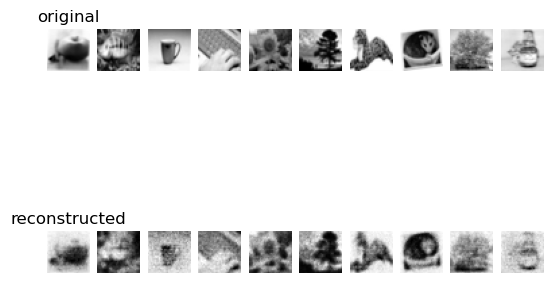

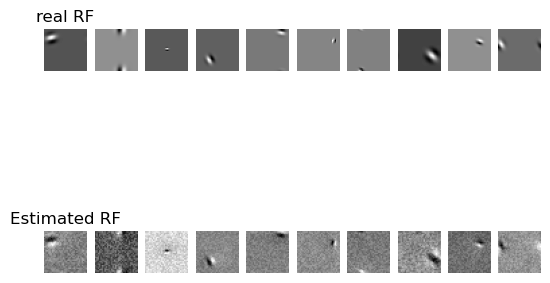

In [8]:

#Now we're into the neural net stuff

#Load the data
(x_train, y_train), (x_test, y_test) = load_data()

#Pick out the useful matrix size parameters
n_train_examples = x_train.shape[0]
n_test_examples = x_test.shape[0]
n_neurons = x_train.shape[1]
n_pix = y_train.shape[1]

print(n_train_examples, n_test_examples, n_neurons, n_pix)

#lets build our model layers
layer1 = tf.keras.Input(shape = (n_neurons,))
layer2 = tf.keras.layers.Dense(n_pix, activation = 'sigmoid')(layer1)

#Now lets define the model
decoder = tf.keras.Model(inputs = layer1,
                         outputs = layer2,
                         name = "decoder")
#Print out the vital stats of our model
decoder.summary()


#Compile the model.
decoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

#Fit the model
decoder.fit(x_train, y_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, y_test))


#Produces the output of the model. I'm pretty sure
#You can call this on layers as well
reconstructed = decoder(x_test).numpy()


#Just plotting the 
fig, axs = plt.subplots(2, 10)
for i in range(10):
    axs[0, i].imshow(y_test[i, :].reshape(32,32), cmap='gray')
    if i == 0:
        axs[0, i].set_title("original")
    axs[0, i].axis('off')

    axs[1,i].imshow(reconstructed[i,:].reshape(32,32), cmap='gray')
    if i == 0:
        axs[1, i].set_title("reconstructed")
    axs[1, i].axis('off')

plt.show()


#Show the learnt receptive fields

#Load the receptive field data
rfs = load_rf()

#Get the learnt weights as biases
weights = decoder.layers[1].get_weights()[0]
biases = decoder.layers[1].get_weights()[1]

fig, axs = plt.subplots(2, 10)
for i in range(10):
    n = np.random.randint(n_neurons)
    axs[0, i].imshow(make_rf(rfs[n, :], 32, 32), cmap='gray')
    if i == 0:
        axs[0, i].set_title("real RF")
    axs[0, i].axis('off')  
    # CHECK THIS NEXT LINE - DO BIASES NEED TO BE ADDED?:  
    # axs[1, i].imshow(weights[n, :].reshape(32,32)+biases[n], cmap='gray') # here the biases come out as the number of pix in the image not num neurons
    axs[1, i].imshow(weights[n, :].reshape(32,32), cmap='gray')
    if i == 0:
        axs[1, i].set_title("Estimated RF")
    axs[1, i].axis('off')

plt.show()
